In [1]:
import torch
from torchvision import transforms
from PIL import Image
from resnet import resnet50
from deepdream import dream

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
input_img = Image.open('./sky.jpg')
input_tensor = img_transform(input_img).unsqueeze(0)
input_np = input_tensor.numpy()

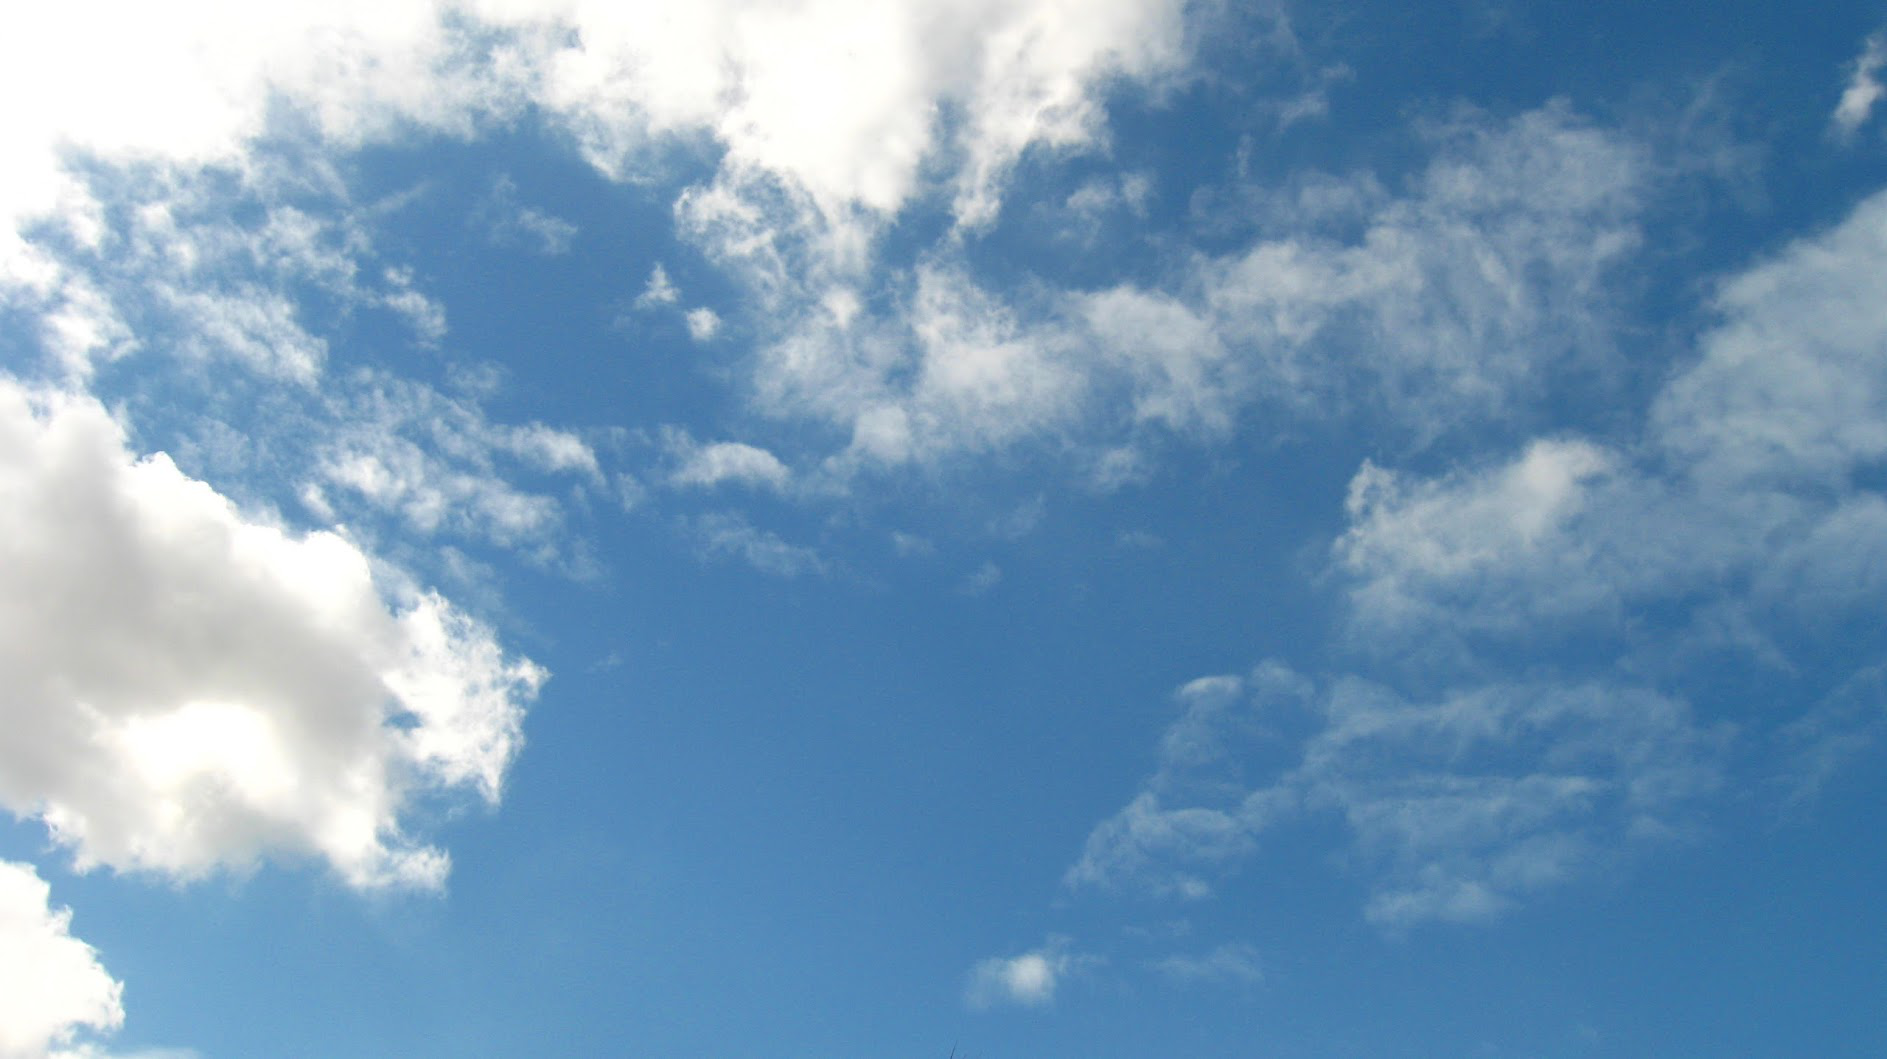

In [4]:
input_img

In [5]:
# load model
model = resnet50(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

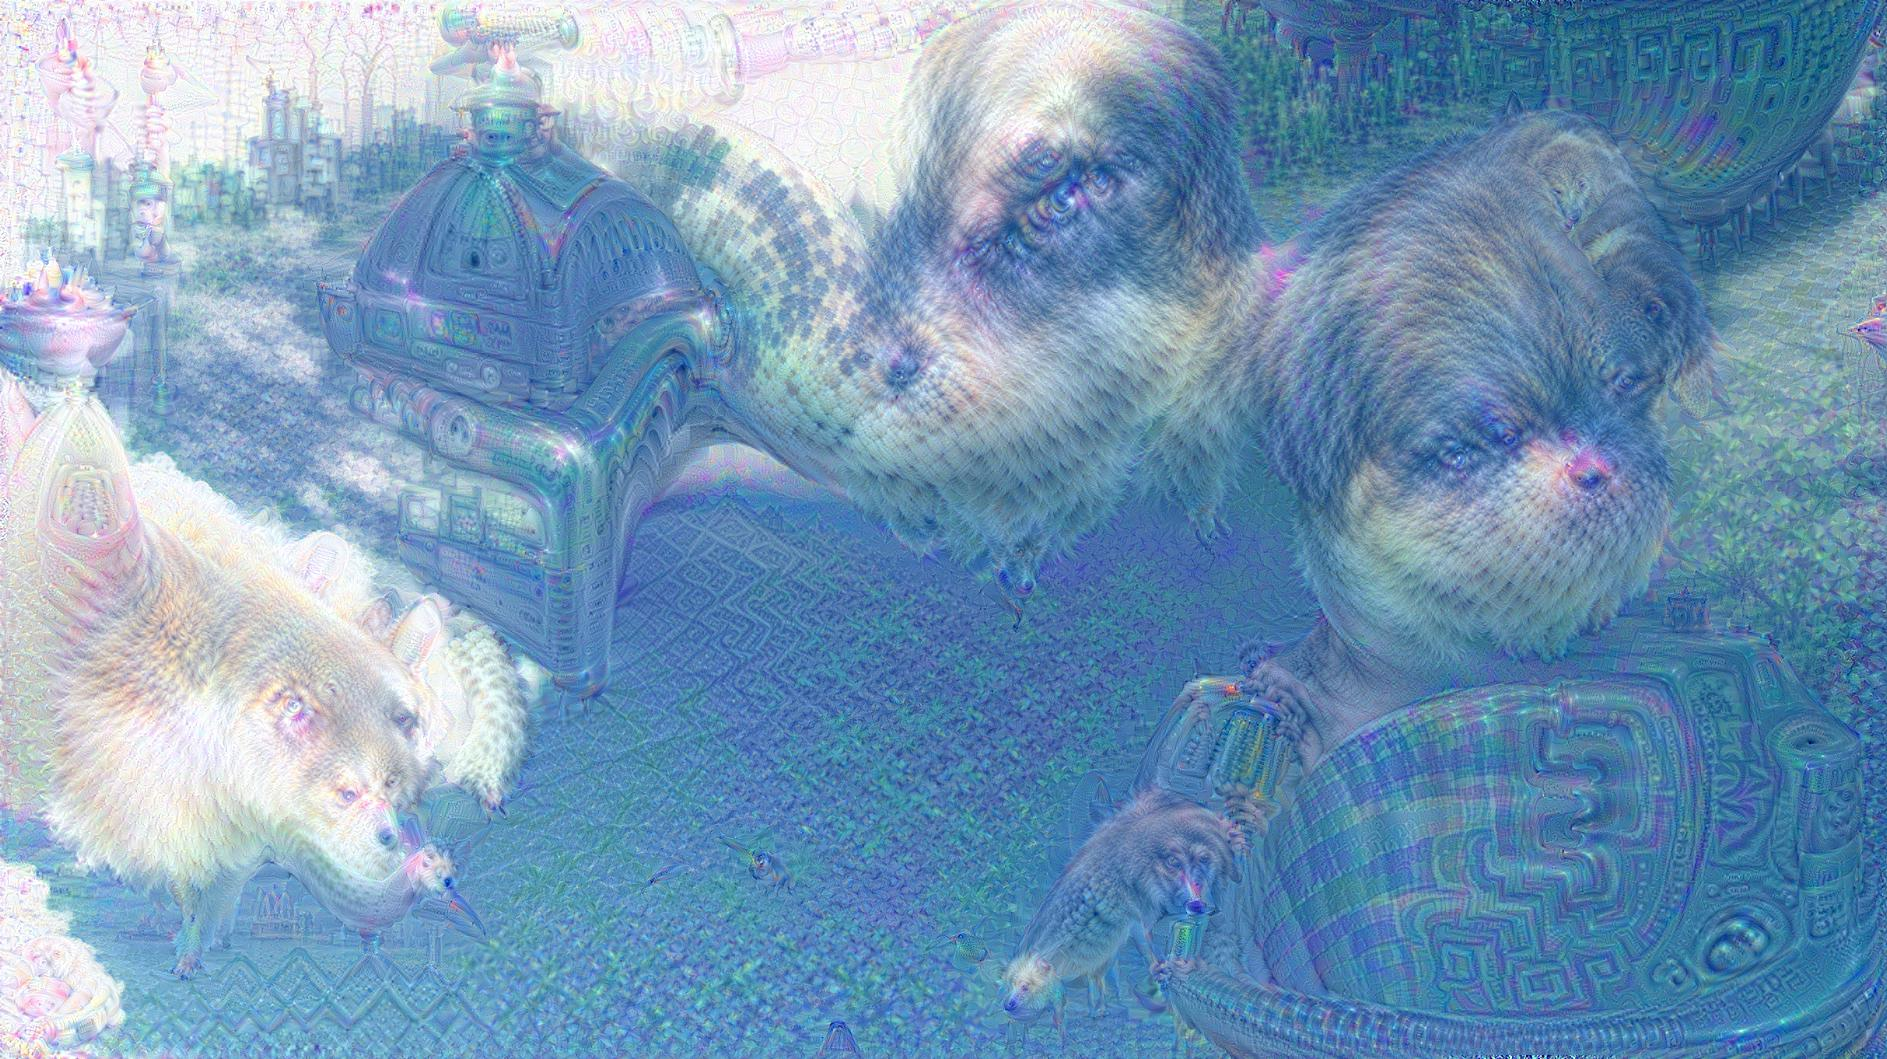

In [6]:
dream(model, input_np)

## Control the dream

In [7]:
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import transforms
import os
from resnet import resnet50
from deepdream import dream
from PIL import Image
from util import showtensor

In [8]:
img_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
inputs_control = Image.open('./guide_image/kitten.jpg')
inputs_control = img_transform(inputs_control).unsqueeze(0)
inputs_control_np = inputs_control.numpy()

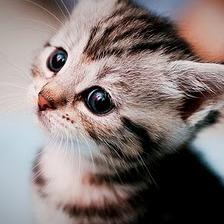

In [9]:
showtensor(inputs_control_np)

In [10]:
model = resnet50(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

if torch.cuda.is_available():
    x_variable = Variable(inputs_control.cuda())
else:
    x_variable = Variable(inputs_control)

control_features = model.forward(x_variable, end_layer=3)

In [11]:
def objective_guide(dst, guide_features):
    x = dst.data[0].cpu().numpy().copy()
    y = guide_features.data[0].cpu().numpy()
    ch, w, h = x.shape
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
    return result

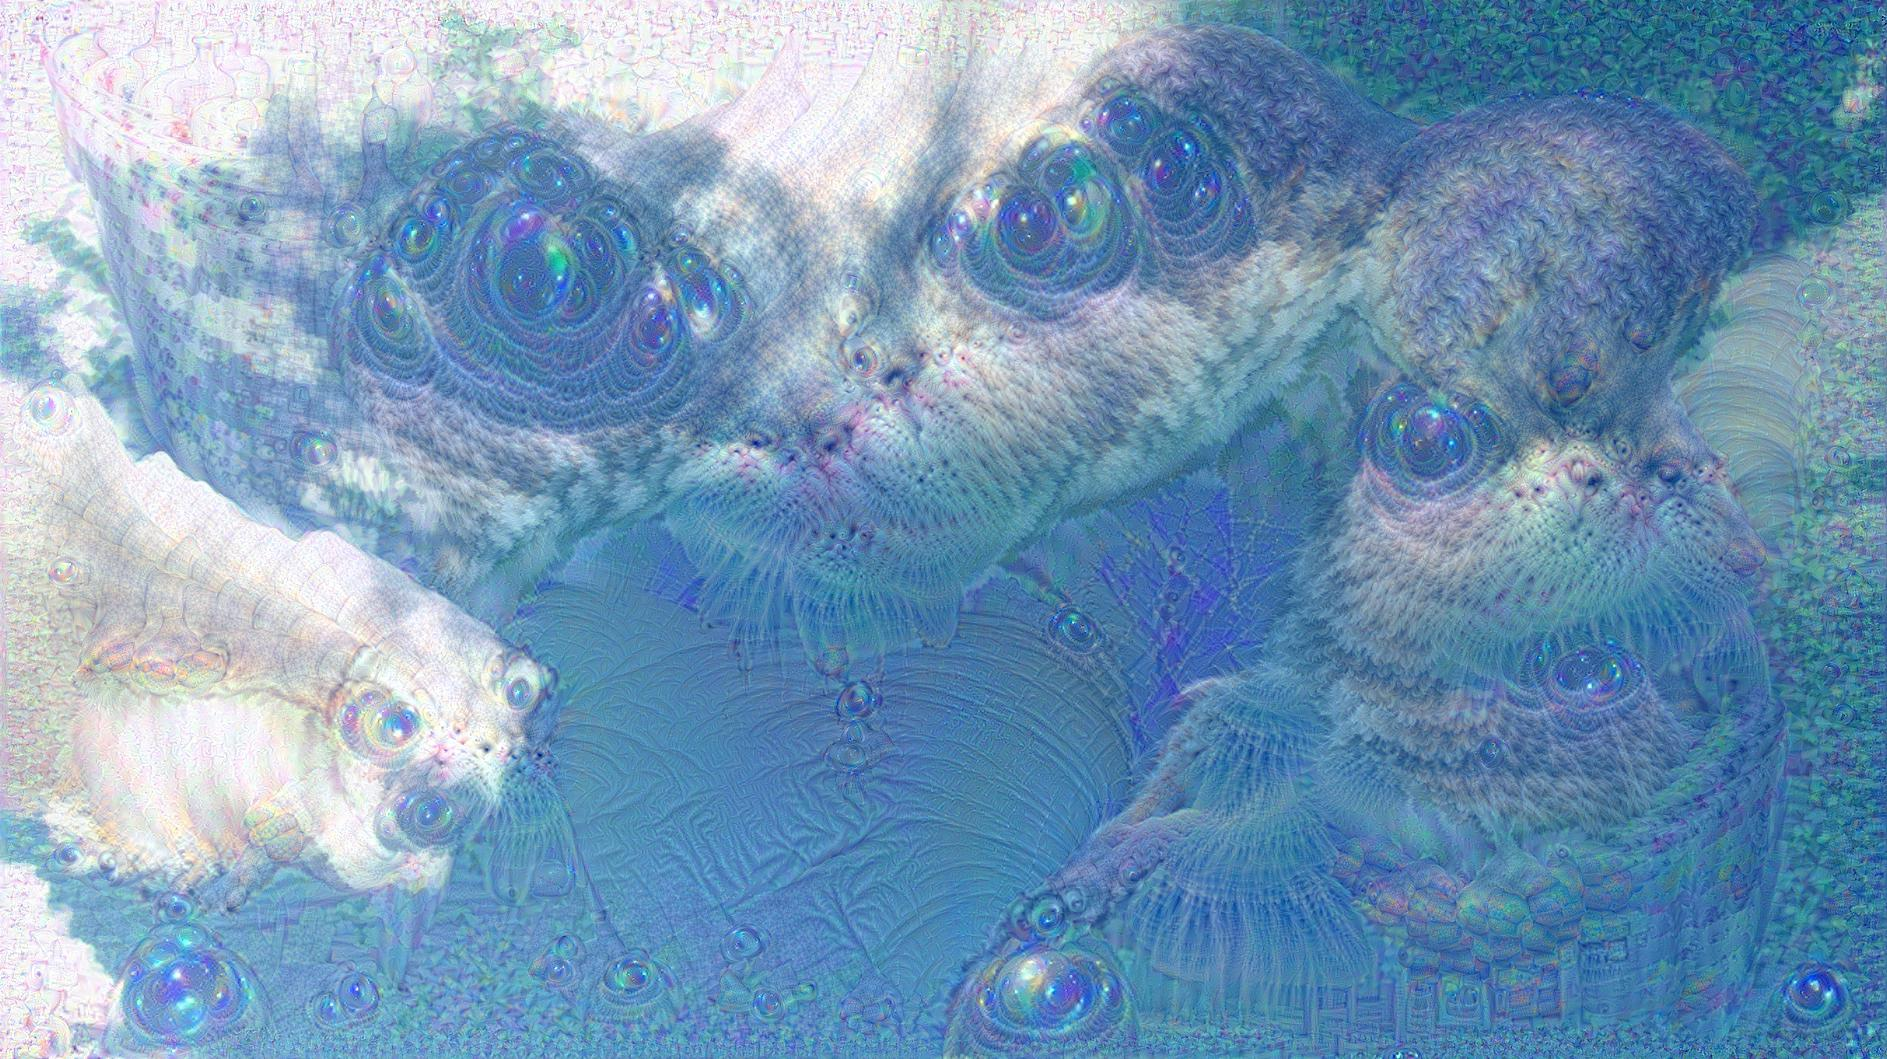

In [12]:
dream(model, input_np, control=control_features, distance=objective_guide)